Charging strategy: GENERATION
Strategy status:   ACTIVE
Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 60
Erster Timestamp: 2025-12-01 00:00:00
Letzter Timestamp: 2025-12-07 23:45:00
Simulationshorizont: 7 Tage
Kalenderische Tage je Tagtyp:
- working_day: 5 Tage
- saturday: 1 Tage
- sunday_holiday: 1 Tage
Ankunftsverhalten bei voller Belegung der Ladepunkte: park_no_charge
Wartetoleranz bei voller Belegung der Ladepunkte [min]: 0

📊 Sessions im Simulationshorizont
BEV-Ankünfte mit Ladebedarf: 865
BEV-Fahrzeuge mit Ladezugang: 485
Anzahl der BEV-Fahrzeuge, die nicht ihr Ziel-SoC erreicht haben: 153


,vehicle_name,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh
0,2 LR SM,2025-12-04 13:18:38.657421,2025-12-04 13:48:38.657421,0.500000,23.750000,33.196007
1,GV60,2025-12-02 06:47:03.342125,2025-12-02 07:17:03.342125,0.500000,23.750000,32.371788
2,ID.7,2025-12-05 08:17:56.672336,2025-12-05 08:47:56.672336,0.500000,23.750000,31.294460
3,EQE SUV,2025-12-04 12:54:50.608990,2025-12-04 13:34:31.669661,0.661406,35.625000,26.524238
4,Q8 e-tron,2025-12-02 07:08:16.616092,2025-12-02 07:44:21.257380,0.601289,23.750000,26.140656
...,...,...,...,...,...,...
148,1# Pro Plus,2025-12-02 09:06:54.172911,2025-12-02 17:22:32.089918,8.260533,17.155970,0.307442
149,Q4 e-tron,2025-12-02 13:28:28.271658,2025-12-02 15:50:33.232251,2.368045,34.729914,0.233393
150,Q8 e-tron,2025-12-05 08:31:24.088490,2025-12-05 18:21:54.829793,9.841873,39.260813,0.160104
151,GV70,2025-12-02 14:02:29.578381,2025-12-02 16:43:38.762022,2.685884,48.044308,0.087677



🚦 Arrival-Blocking KPIs
Rejected (drive_off / max_wait): 0
Parked but not charged: 380

🔎 Beispiel-Sessions (erste 10):
Fahrzeug: Taycan, Ankunft: 2025-12-01 05:55:45.730042, Abfahrt: 2025-12-01 11:43:32.328337, Kapazität: 93.0 kWh, geladene Energie: 21.8 kWh, Restbedarf: 0.0 kWh, angesteckt: Ja
Fahrzeug: IONIQ 6, Ankunft: 2025-12-01 06:43:12.060572, Abfahrt: 2025-12-01 07:40:59.937726, Kapazität: 77.0 kWh, geladene Energie: 43.5 kWh, Restbedarf: 1.0 kWh, angesteckt: Ja
Fahrzeug: 1# Pro Plus, Ankunft: 2025-12-01 06:59:35.653250, Abfahrt: 2025-12-01 07:49:14.841919, Kapazität: 66.0 kWh, geladene Energie: 22.4 kWh, Restbedarf: 0.0 kWh, angesteckt: Ja
Fahrzeug: Model X, Ankunft: 2025-12-01 07:07:15.667620, Abfahrt: 2025-12-01 11:00:28.984131, Kapazität: 100.0 kWh, geladene Energie: 17.4 kWh, Restbedarf: 0.0 kWh, angesteckt: Ja
Fahrzeug: IONIQ 6, Ankunft: 2025-12-01 07:08:36.038196, Abfahrt: 2025-12-01 14:25:27.368726, Kapazität: 77.0 kWh, geladene Energie: 19.4 kWh, Restbedarf: 0.0 kWh, 

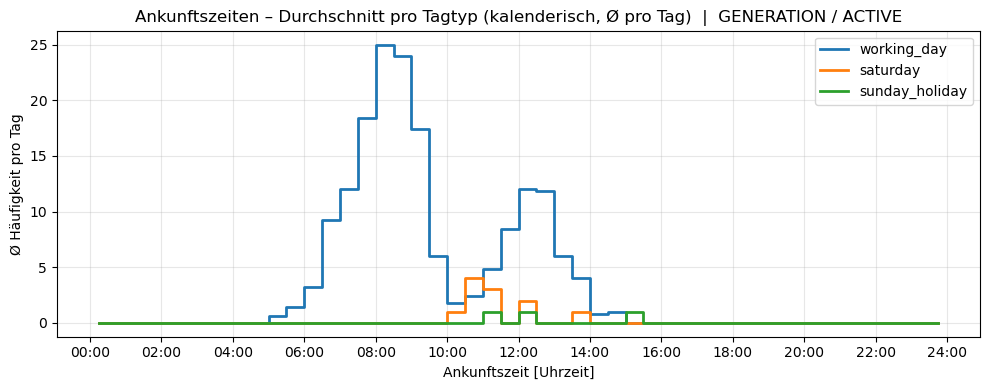

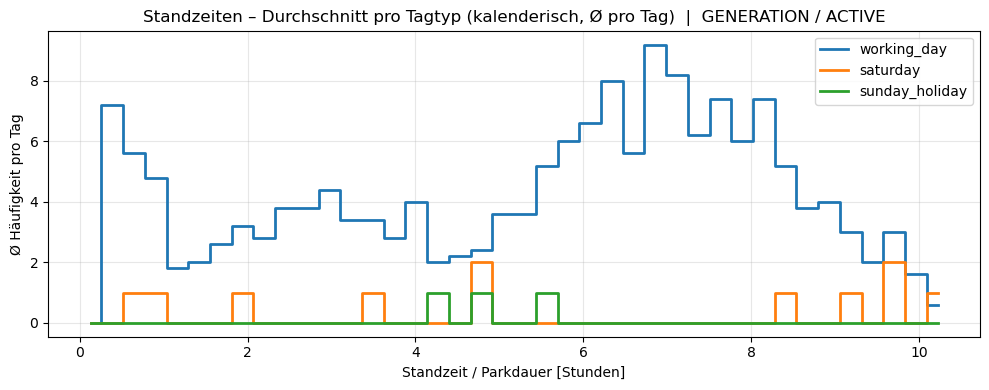

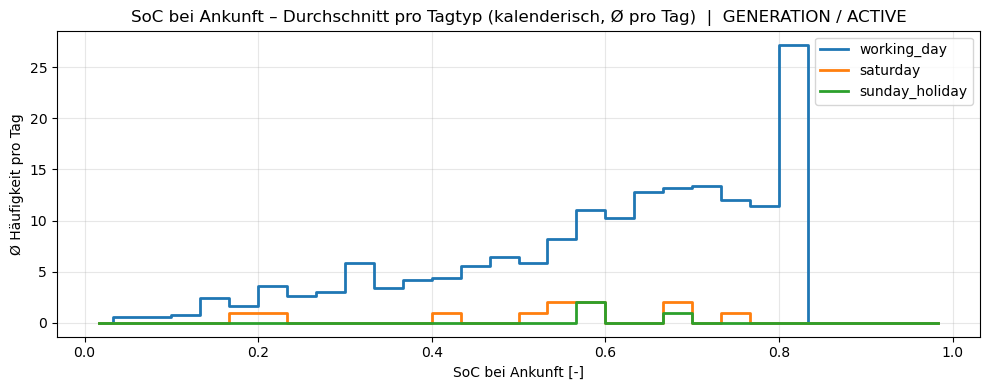

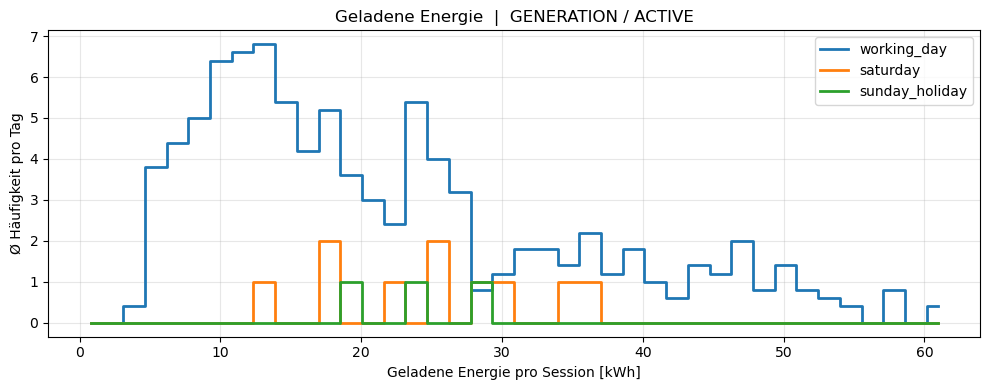

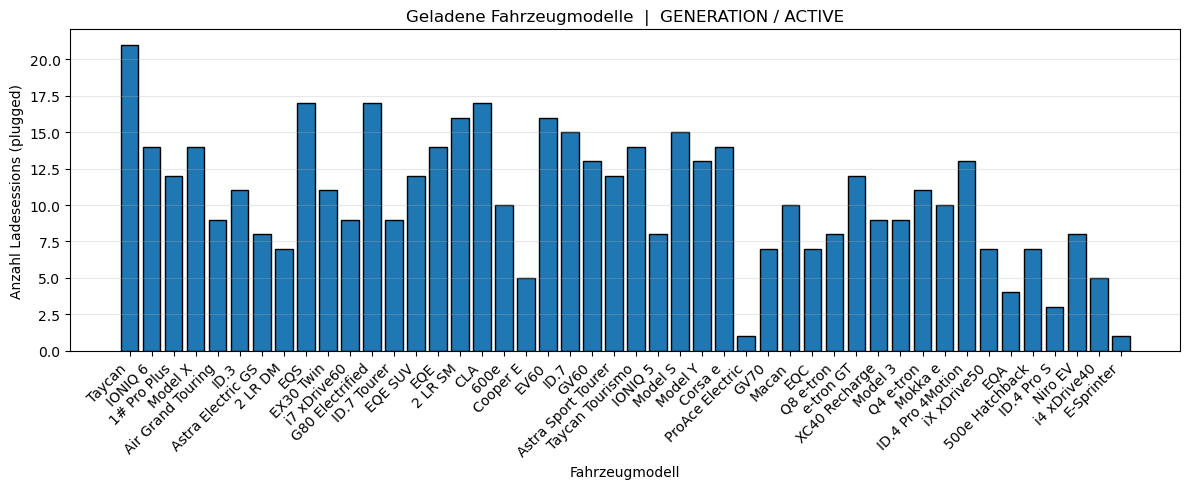

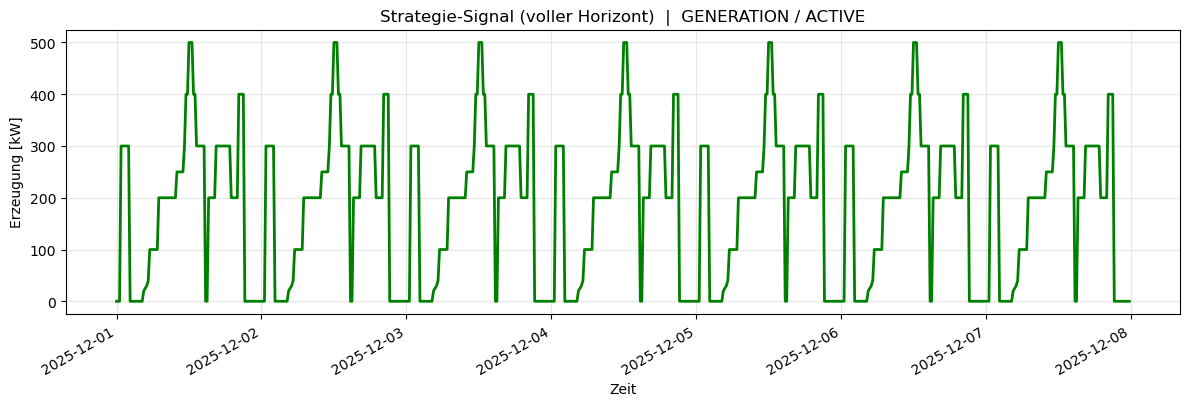

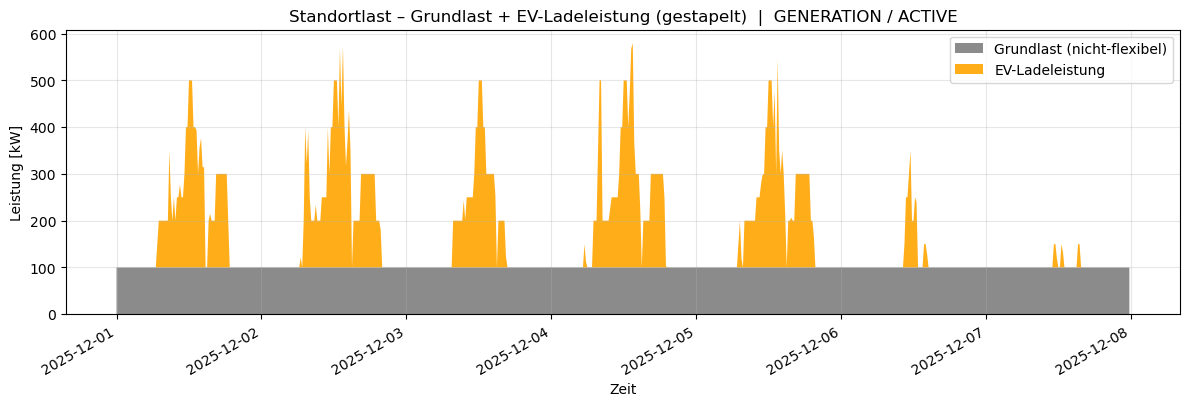

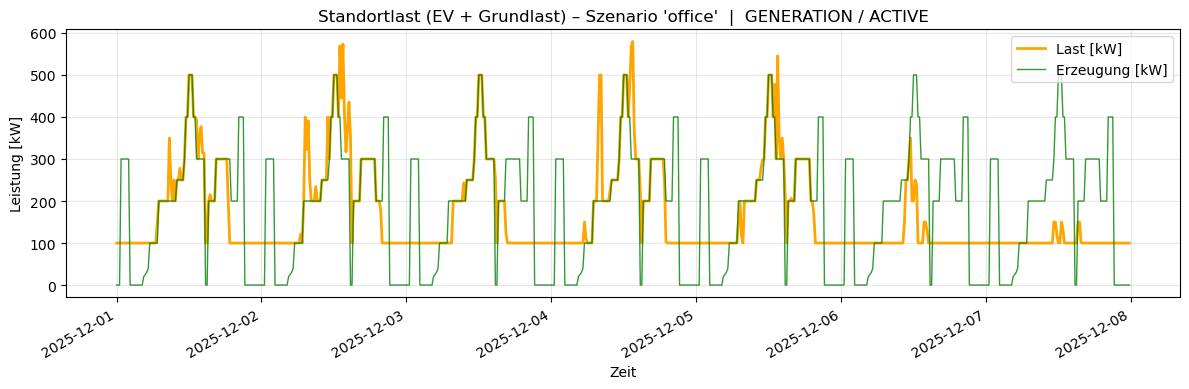

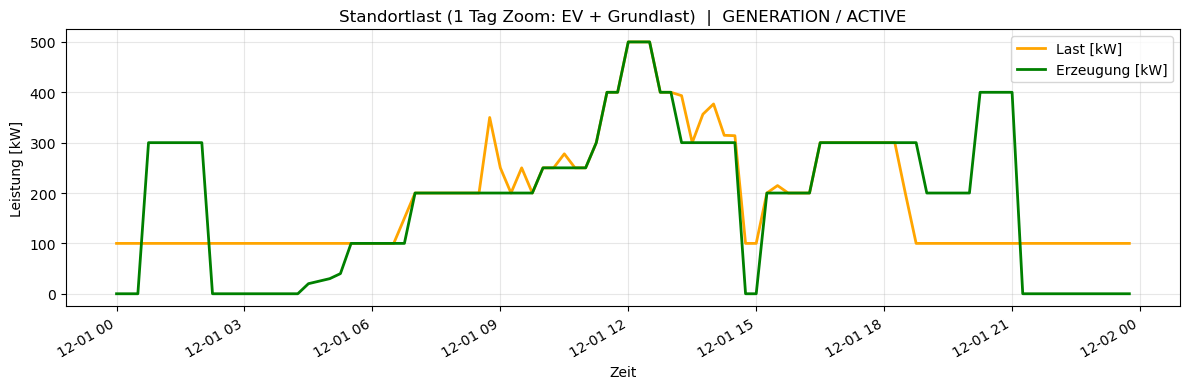


Zeitschritte mit ungenutztem PV-Strom: 25


,ts,pv_surplus_kw,site_power_kw,grid_import_kw,n_rows,pv_unused_kw
239,2025-12-07 12:30:00,400.0,50.000000,0.0,1,350.000000
230,2025-12-06 12:00:00,400.0,100.000000,0.0,2,300.000000
238,2025-12-07 11:45:00,300.0,19.105847,0.0,1,280.894153
240,2025-12-07 12:45:00,300.0,33.066825,0.0,1,266.933175
232,2025-12-06 12:30:00,400.0,140.148367,0.0,3,259.851633
231,2025-12-06 12:15:00,400.0,150.000000,0.0,3,250.000000
237,2025-12-07 11:30:00,300.0,50.000000,0.0,1,250.000000
229,2025-12-06 11:45:00,300.0,100.000000,0.0,2,200.000000
128,2025-12-03 16:30:00,200.0,22.841325,0.0,1,177.158675
235,2025-12-06 14:15:00,200.0,28.382076,0.0,1,171.617924


In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from collections import Counter, defaultdict
from datetime import datetime, timedelta, date

warnings.simplefilter("always", UserWarning)
from IPython.display import display, HTML


# =============================================================================
# 0) Plot-Farben (global konsistent)
# =============================================================================
COLOR_GENERATION = "green"    # Erzeugung / PV / Strategy (generation)
COLOR_LOAD = "orange"         # Last / EV / Standortlast
COLOR_BASELOAD = "#7f7f7f"    # Grundlast (neutral grau)


# =============================================================================
# 0) Notebook-UI Helpers
# =============================================================================

def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 1) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import load_scenario, simulate_load_profile

# build_strategy_signal_series ist optional (kann in älteren Versionen fehlen)
try:
    from model.simulation import build_strategy_signal_series  # optional
except Exception:
    build_strategy_signal_series = None


# =============================================================================
# 2) Szenario laden und Simulation durchführen
# =============================================================================

scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"
scenario = load_scenario(scenario_path)

try:
    (
        timestamps,
        load_kw,
        sessions,
        charging_counts,
        holiday_dates,
        charging_strategy,
        strategy_status,
        debug_rows,
    ) = simulate_load_profile(scenario, record_debug=True)

except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    timestamps = load_kw = sessions = charging_counts = holiday_dates = None
    charging_strategy = strategy_status = None
    debug_rows = None

if charging_strategy is not None and strategy_status is not None:
    show_strategy_status_html(charging_strategy, strategy_status)
    print(f"Charging strategy: {charging_strategy.upper()}")
    print(f"Strategy status:   {strategy_status}")


# =============================================================================
# 2b) Strategie-Signalreihe (aligned) + Labels (optional)
# =============================================================================

strategy_series = None
strategy_ylabel = None

if (
    timestamps is not None
    and charging_strategy is not None
    and charging_strategy.lower() in ("market", "generation")
    and build_strategy_signal_series is not None
):
    strategy_series, strategy_ylabel = build_strategy_signal_series(
        scenario=scenario,
        timestamps=timestamps,
        charging_strategy=charging_strategy,
        normalize_to_internal=True,  # market -> €/kWh, generation -> kW
        strategy_resolution_min=15,
    )


# =============================================================================
# 3) Kontrollen
# =============================================================================

if timestamps is not None:
    print("Verwendetes Szenario:", scenario_name)
    print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
    print(f"Erster Timestamp: {timestamps[0]}")
    print(f"Letzter Timestamp: {timestamps[-1]}")
    print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")


# =============================================================================
# 4) Day-Type-Logik lokal im Notebook
# =============================================================================

def determine_day_type_notebook(dt: datetime, holiday_dates: set[date]):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"


# =============================================================================
# 5) Feature-Helper pro Session
# =============================================================================

def minutes_since_midnight(dt: datetime) -> float:
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s) -> float:
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s) -> float:
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s) -> float:
    return float(s["soc_arrival"])

def feat_delivered_kwh(s) -> float:
    return float(s.get("delivered_energy_kwh", 0.0))


# =============================================================================
# 6) Tage kalendarisch zählen
# =============================================================================

days_by_type_calendar = defaultdict(list)

if timestamps is not None and holiday_dates is not None:
    start_dt = datetime.fromisoformat(scenario["start_datetime"])
    horizon_days = int(scenario["simulation_horizon_days"])
    all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

    for d in all_days:
        dt_midday = datetime(d.year, d.month, d.day, 12, 0)
        day_type = determine_day_type_notebook(dt_midday, holiday_dates)
        days_by_type_calendar[day_type].append(d)

    print("Kalenderische Tage je Tagtyp:")
    for k in ["working_day", "saturday", "sunday_holiday"]:
        print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 7) Kontrollen: Sessions (gekürzt)
# =============================================================================

df_debug = pd.DataFrame(debug_rows) if debug_rows else pd.DataFrame()

if sessions is not None:
    num_sessions_total = len(sessions)
    num_sessions_plugged = sum(1 for s in sessions if s.get("_plug_in_time") is not None)

    print("\n📊 Sessions im Simulationshorizont")
    print("BEV-Ankünfte mit Ladebedarf:", num_sessions_total)
    print("BEV-Fahrzeuge mit Ladezugang:", num_sessions_plugged)
    
    
    # =============================================================================
    # Ziel-SoC nicht erreicht – Detailtabelle (nur physisch angesteckte Fahrzeuge)
    # =============================================================================

    eps_kwh = 1e-6  # numerische Toleranz

    if sessions is not None:
        rows = []

        for s in sessions:
            # nur physisch angesteckt
            if s.get("_plug_in_time") is None:
                continue

            # Ziel-SoC nicht erreicht
            if float(s.get("energy_required_kwh", 0.0)) <= eps_kwh:
                continue

            arrival = s["arrival_time"]
            departure = s["departure_time"]

            rows.append(
                {
                    "vehicle_name": s.get("vehicle_name", ""),
                    "arrival_time": arrival,
                    "departure_time": departure,
                    "parking_hours": (departure - arrival).total_seconds() / 3600.0,
                    "delivered_energy_kwh": float(s.get("delivered_energy_kwh", 0.0)),
                    "remaining_energy_kwh": float(s.get("energy_required_kwh", 0.0)),
                }
            )

        if len(rows) == 0:
            print("Alle BEV-Fahrzeuge haben ihr Ziel-SoC erreicht.")
        else:
            df_not_reached_plugged = pd.DataFrame(rows)

            df_not_reached_plugged = df_not_reached_plugged.sort_values(
                by="remaining_energy_kwh",
                ascending=False,
            ).reset_index(drop=True)

            print(f"Anzahl der BEV-Fahrzeuge, die nicht ihr Ziel-SoC erreicht haben: {len(df_not_reached_plugged)}")
            display(df_not_reached_plugged)


    # optional: Arrival-Blocking KPIs
    num_rejected = sum(1 for s in sessions if bool(s.get("_rejected", False)))
    print("BEV ohne Ladezugang:", num_rejected)

    print("\n🔎 Beispiel-Sessions (erste 10):")
    for s in sessions[:10]:
        print(
            f"Fahrzeug: {s.get('vehicle_name','')}, "
            f"Ankunft: {s['arrival_time']}, "
            f"Abfahrt: {s['departure_time']}, "
            f"Kapazität: {s['battery_capacity_kwh']:.1f} kWh, "
            f"geladene Energie: {float(s.get('delivered_energy_kwh', 0.0)):.1f} kWh, "
            f"Restbedarf: {float(s.get('energy_required_kwh', 0.0)):.1f} kWh, "
            f"angesteckt: {'Ja' if s.get('_plug_in_time') else 'Nein'}"
        )    


# =============================================================================
# 8) Sessions nach Datum gruppieren (für Histogramme pro Tag)
#    + zusätzlich: nur physisch angesteckte Sessions
# =============================================================================

sessions_by_day = defaultdict(list)
sessions_by_day_plugged = defaultdict(list)

if sessions is not None:
    for s in sessions:
        d = s["arrival_time"].date()
        sessions_by_day[d].append(s)

        # nur physisch angesteckt (hatte mindestens einmal _plug_in_time)
        if s.get("_plug_in_time") is not None:
            sessions_by_day_plugged[d].append(s)


# =============================================================================
# 9) Histogramm-Helfer
# =============================================================================

def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type


def plot_avg_hist_overlay(
    avg_counts_by_type,
    bin_edges,
    xlabel,
    base_title,
    charging_strategy,
    strategy_status,
    xticks=None,
    xtick_labels=None,
):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 10) Ankunftszeiten (alle Sessions)
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    arrival_bin_edges = np.linspace(0, 24, 49)

    avg_arrival = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_arrival_hours,
        bin_edges=arrival_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_arrival,
        bin_edges=arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )


# =============================================================================
# 11) Standzeiten (alle Sessions)
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
    max_p = max(max_p, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)

    avg_parking = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_parking_hours,
        bin_edges=parking_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_parking,
        bin_edges=parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 12) SoC bei Ankunft (alle Sessions)
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    soc_bin_edges = np.linspace(0, 1, 31)

    avg_soc = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day,
        value_fn=feat_soc_arrival,
        bin_edges=soc_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_soc,
        bin_edges=soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 13) Geladene Energie (NUR physisch angesteckte Sessions)
# =============================================================================

if timestamps is not None and sessions is not None and days_by_type_calendar:
    # nur plugged für sinnvolle Achsenskalierung
    plugged_list = [s for s in sessions if s.get("_plug_in_time") is not None]
    all_energy = np.array([feat_delivered_kwh(s) for s in plugged_list], dtype=float)

    max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
    max_e = max(max_e, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)

    avg_energy = average_hist_per_daytype_calendar(
        daytype_to_days=days_by_type_calendar,
        sessions_by_day=sessions_by_day_plugged,  # ✅ wichtig: plugged-only
        value_fn=feat_delivered_kwh,
        bin_edges=energy_bin_edges,
    )

    plot_avg_hist_overlay(
        avg_counts_by_type=avg_energy,
        bin_edges=energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 14) Fahrzeugzählung (nur physisch angesteckte Fahrzeuge)
# =============================================================================

if sessions is not None:
    sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]

    vehicle_names = [s.get("vehicle_name", "") for s in sessions_plugged]
    counts = Counter(vehicle_names)

    models = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(12, 5))
    plt.bar(models, values, edgecolor="black")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Fahrzeugmodell")
    plt.ylabel("Anzahl Ladesessions (plugged)")
    plt.title(decorate_title_with_status(
        "Geladene Fahrzeugmodelle",
        charging_strategy,
        strategy_status,
    ))
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


# =============================================================================
# 15) Strategy-Only Plot (optional) — Farben angepasst
# =============================================================================

if timestamps is not None and strategy_series is not None and strategy_ylabel is not None:
    plt.figure(figsize=(12, 4))

    strat = (charging_strategy or "immediate").lower()
    if strat == "generation":
        sig_color = COLOR_GENERATION
    else:
        sig_color = None  # market: Farbe nicht gefordert; default ok

    plt.plot(timestamps, strategy_series, linewidth=2, color=sig_color)
    plt.xlabel("Zeit")
    plt.ylabel(strategy_ylabel)
    plt.title(decorate_title_with_status("Strategie-Signal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 16) Lastprofil + Strategie integriert (optional) — Farben angepasst
# =============================================================================

def plot_load_with_strategy(
    timestamps: list[datetime],
    load_kw: np.ndarray,
    strategy_series: np.ndarray | None,
    strategy_ylabel: str | None,
    base_title: str,
    charging_strategy: str,
    strategy_status: str,
    start_idx: int | None = None,
    end_idx: int | None = None,
    strategy_linewidth: float = 2.0,
    strategy_alpha: float = 1.0,
):
    if start_idx is None:
        start_idx = 0
    if end_idx is None:
        end_idx = len(timestamps)

    x = timestamps[start_idx:end_idx]
    y_load = load_kw[start_idx:end_idx]

    strat = (charging_strategy or "immediate").lower()

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # Last immer orange
    l1 = ax1.plot(x, y_load, label="Last [kW]", color=COLOR_LOAD, linewidth=2)
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    handles = []
    labels = []
    handles += l1
    labels += ["Last [kW]"]

    if strategy_series is not None and strategy_ylabel is not None:
        y_sig = strategy_series[start_idx:end_idx]

        if strat == "market":
            ax2 = ax1.twinx()
            # market: keine Farb-Vorgabe (wenn du willst, sag Bescheid)
            l2 = ax2.plot(x, y_sig, linewidth=strategy_linewidth, alpha=strategy_alpha, label=strategy_ylabel)
            ax2.set_ylabel(strategy_ylabel)
            handles += l2
            labels += [strategy_ylabel]

        elif strat == "generation":
            # generation: überall grün
            l2 = ax1.plot(
                x, y_sig,
                linewidth=strategy_linewidth,
                alpha=strategy_alpha,
                label=strategy_ylabel,
                color=COLOR_GENERATION,
            )
            handles += l2
            labels += [strategy_ylabel]

    ax1.set_title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    ax1.legend(handles, labels, loc="upper right")

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# =============================================================================
# Zusatz: Grundlast-Zeitreihe für Notebook-Plots aufbauen (optional)
# =============================================================================

from model.simulation import build_base_load_series

base_load_kw_series = None
if timestamps is not None:
    base_load_kw_series = build_base_load_series(
        scenario=scenario,
        timestamps=timestamps,
        base_load_resolution_min=15,
    )

if base_load_kw_series is None and load_kw is not None:
    base_load_kw_series = np.zeros_like(load_kw)

if load_kw is not None and base_load_kw_series is not None:
    site_load_kw = load_kw + base_load_kw_series
else:
    site_load_kw = load_kw


# =============================================================================
# 17) Standortlast – gestapelt: Grundlast + EV-Last — Farben angepasst
# =============================================================================

if timestamps is not None and load_kw is not None and base_load_kw_series is not None:
    plt.figure(figsize=(12, 4))
    plt.stackplot(
        timestamps,
        base_load_kw_series,
        load_kw,
        labels=["Grundlast (nicht-flexibel)", "EV-Ladeleistung"],
        colors=[COLOR_BASELOAD, COLOR_LOAD],
        alpha=0.9,
    )
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(decorate_title_with_status("Standortlast – Grundlast + EV-Ladeleistung (gestapelt)", charging_strategy, strategy_status))
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 18) Standortlast (EV + Grundlast) – voller Horizont
# =============================================================================

if timestamps is not None and site_load_kw is not None:
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title=f"Standortlast (EV + Grundlast) – Szenario '{scenario_name}'",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        strategy_linewidth=1.0,
        strategy_alpha=0.8,
    )


# =============================================================================
# 19) Standortlast (EV + Grundlast) – 1 Tag Zoom
# =============================================================================

if timestamps is not None and site_load_kw is not None:
    steps_per_day = int(24 * 60 / scenario["time_resolution_min"])
    plot_load_with_strategy(
        timestamps=timestamps,
        load_kw=site_load_kw,
        strategy_series=strategy_series,
        strategy_ylabel=strategy_ylabel,
        base_title="Standortlast (1 Tag Zoom: EV + Grundlast)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        start_idx=0,
        end_idx=min(steps_per_day, len(timestamps)),
    )


# =============================================================================
# 20) PV: Zeitschritte mit ungenutztem PV-Strom
# =============================================================================

if debug_rows is not None and len(debug_rows) > 0:
    df_debug = pd.DataFrame(debug_rows).copy()

    # Datetime sicherstellen
    df_debug["ts"] = pd.to_datetime(df_debug.get("ts", pd.NaT), errors="coerce")

    required_cols = {"ts", "pv_surplus_kw", "site_total_power_kw"}
    if required_cols.issubset(df_debug.columns):

        # optional: nur Zeilen mit PV-Überschuss
        df_pv = df_debug[df_debug["pv_surplus_kw"] > 1e-6].copy()

        if len(df_pv) == 0:
            print("\nZeitschritte mit ungenutztem PV-Strom: 0")
        else:
            # Netzimport (wenn vorhanden, sonst 0.0)
            grid_col = "grid_import_kw_site" if "grid_import_kw_site" in df_pv.columns else None

            pv_steps = (
                df_pv
                .groupby("ts", as_index=False)
                .agg(
                    pv_surplus_kw=("pv_surplus_kw", "first"),
                    site_power_kw=("site_total_power_kw", "first"),
                    grid_import_kw=(grid_col, "first") if grid_col else ("pv_surplus_kw", lambda x: 0.0),
                    n_rows=("vehicle_name", "count") if "vehicle_name" in df_pv.columns else ("pv_surplus_kw", "size"),
                )
            )

            pv_steps["pv_unused_kw"] = (pv_steps["pv_surplus_kw"] - pv_steps["site_power_kw"]).clip(lower=0.0)

            pv_unused_steps = pv_steps[pv_steps["pv_unused_kw"] > 1e-3].copy()
            pv_unused_steps = pv_unused_steps.sort_values(["pv_unused_kw", "ts"], ascending=[False, True])

            print(f"\nZeitschritte mit ungenutztem PV-Strom: {len(pv_unused_steps)}")
            display(pv_unused_steps[["ts", "pv_surplus_kw", "site_power_kw", "grid_import_kw", "n_rows", "pv_unused_kw"]].head(50))

    else:
        print("\nPV-Analyse übersprungen – benötigte Spalten fehlen.")
        print("Benötigt:", required_cols)
        print("Vorhanden:", set(df_debug.columns))
else:
    print("\nPV-Analyse übersprungen – keine debug_rows vorhanden (record_debug=True aktivieren oder Simulation abgebrochen).")
